In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from datetime import datetime
import os

In [18]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [19]:
basedir = '/content/gdrive/MyDrive/ColabNotebooks/00_Data/'
logdir = f'{basedir}ProjektStudium/logs/Sine_TimeSeries/' + datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(logdir)

# Data

In [1]:
step = 5
offset = 1

Train

In [5]:
x_train = np.arange(0, 10000, 0.5)
y_train = np.sin(x_train)

Test

In [6]:
x_test = np.array([0, 0.5, 1, 0.5, 0]) # initial values
y_test = np.array([-0.5, -1, -0.5]) # expected predictions

In [7]:
test = np.array([0, 0.5, 1, 0.5, 0, -0.5, -1, -0.5])

# Windowing

In [8]:
def create_windows(dataset, step=1):
  x = []
  y = []

  for i in range(len(dataset) - step -1):
    window = dataset[i : (i+step)]
    x.append(window)
    y.append(dataset[i + step])

  return np.array(x), np.array(y)

In [9]:
trainX, trainY = create_windows(y_train, step)
testX, testY = create_windows(test, step)

In [10]:
print(f"Training shape: {trainX.shape}")
print(f"Testing shape: {testX.shape}")

Training shape: (19994, 5)
Testing shape: (2, 5)


Reshape [samples, timesteps, features]

In [11]:
def create_series(dataset):
  return np.reshape(dataset, (dataset.shape[0], 1, dataset.shape[1]))

In [12]:
trainX_series = create_series(trainX)
testX_series = create_series(testX)

In [14]:
print(f"Training shape: {trainX_series.shape}")
print(f"Testing shape: {testX_series.shape}")

Training shape: (19994, 1, 5)
Testing shape: (2, 1, 5)


# Model

In [16]:
model = keras.Sequential()
model.add(layers.LSTM(32, input_shape=(None, step)))
model.add(layers.Dense(units=1))

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

In [20]:
%load_ext tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [21]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()])

In [101]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


# Training


In [22]:
history = model.fit(trainX_series, trainY, epochs=30,
                      batch_size=1, validation_split=0.2,
                      callbacks=[early_stopping, tensorboard_callback])

Epoch 1/30
15995/15995 [==============================] - 77s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0086 - accuracy: 0.0000e+00 - val_loss: 4.9946e-05 - val_mean_absolute_error: 0.0056 - val_accuracy: 0.0000e+00
Epoch 2/30
15995/15995 [==============================] - 65s 4ms/step - loss: 3.5961e-05 - mean_absolute_error: 0.0036 - accuracy: 0.0000e+00 - val_loss: 1.8160e-04 - val_mean_absolute_error: 0.0110 - val_accuracy: 0.0000e+00
Epoch 3/30
15995/15995 [==============================] - 82s 5ms/step - loss: 2.6683e-05 - mean_absolute_error: 0.0030 - accuracy: 1.2504e-04 - val_loss: 1.2297e-06 - val_mean_absolute_error: 9.1896e-04 - val_accuracy: 0.0000e+00
Epoch 4/30
15995/15995 [==============================] - 69s 4ms/step - loss: 2.6566e-05 - mean_absolute_error: 0.0027 - accuracy: 0.0000e+00 - val_loss: 1.0130e-05 - val_mean_absolute_error: 0.0028 - val_accuracy: 0.0000e+00
Epoch 5/30
15995/15995 [==============================] - 87s 5ms/step - loss: 2.6877e-05 - 

In [23]:
model.save(f'/{basedir}ProjektStudium/sine_model.h5')

# Predict

In [ ]:
model = keras.models.load_model(f'{basedir}ProjektStudium/sine_model.h5')

In [69]:
def sliding_predictions(test_data, n_predictions):
  data = test_data # copy
  all_predictions = []
  for i in range(n_predictions):
    x, y = create_windows(data, step)
    series = create_series(x)
    prediction = model.predict(series)

    data = np.append(data, prediction[-1])
    all_predictions = np.append(all_predictions, prediction[-1])

  return all_predictions

Training Data

In [24]:
train_predict = model.predict(trainX_series)

625/625 [==============================] - 6s 8ms/step


Testing Data

In [ ]:
test_predict = sliding_predictions(test, 20)

Larger Test Series

In [70]:
x_test2_axis = np.arange(0,50,1)
data_test2 = np.sin(x_test2_axis)
test2_predict = sliding_predictions(data_test2, 50-step)

3/3 [==============================] - 0s 4ms/step


## Plot

In [65]:
def plot_predictions(x, expected, predictions):
  fig, ax = plt.subplots(1, 1, figsize=(12,8))
  # Plot expected
  ax.plot(x, expected, lw=1, c='b', label='expected')
  # Plot predictions
  ax.plot(x[step :], predictions, lw=1, linestyle=':', c='r', label='prediction')
  plt.scatter(x[step :], predictions, marker='.', c='r')
  # Plot
  ax.legend(loc='lower left')
  limit = 50
  if len(predictions) < limit:
    limit = len(predictions) + step
  plt.xlim(0, limit)
  plt.ylim(-1.5, 1.5)
  plt.title('Predicted Sine Wave')
  plt.show()

In [30]:
def print_differences(expected, predictions):
  for i in range(len(predictions)):
    if i > 50:
      return
    e = expected[i]
    p = predictions[i]
    print(f'Expected: {e} ==> Predicted: {p} ==> Diff: {e - p}')

Training Data

Training Data Predictions


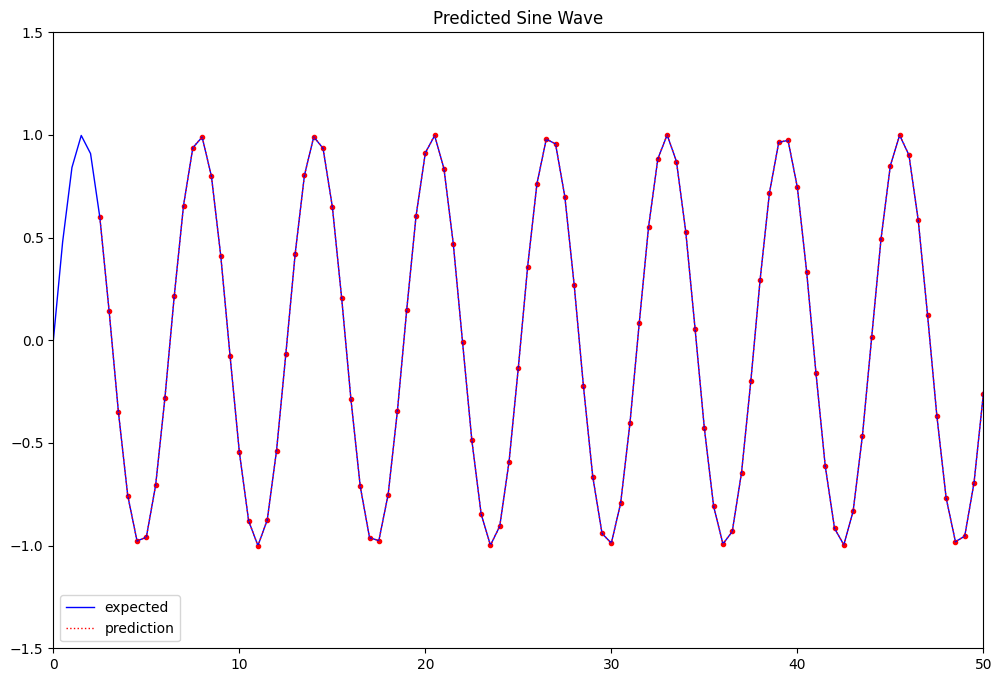

In [68]:
print("Training Data Predictions")
train_predict_sq = np.squeeze(train_predict)
plot_predictions(x_train[:-1], y_train[:-1], train_predict_sq)

In [31]:
print_differences(y_train, train_predict_sq)

Expected: 0.0 ==> Predicted: 0.5979647040367126 ==> Diff: -0.5979647040367126
Expected: 0.479425538604203 ==> Predicted: 0.14061933755874634 ==> Diff: 0.33880620104545667
Expected: 0.8414709848078965 ==> Predicted: -0.3504537045955658 ==> Diff: 1.1919246894034623
Expected: 0.9974949866040544 ==> Predicted: -0.7568506598472595 ==> Diff: 1.754345646451314
Expected: 0.9092974268256817 ==> Predicted: -0.9777708053588867 ==> Diff: 1.8870682321845684
Expected: 0.5984721441039565 ==> Predicted: -0.9587011337280273 ==> Diff: 1.5571732778319838
Expected: 0.1411200080598672 ==> Predicted: -0.7059599757194519 ==> Diff: 0.8470799837793191
Expected: -0.35078322768961984 ==> Predicted: -0.27986231446266174 ==> Diff: -0.0709209132269581
Expected: -0.7568024953079282 ==> Predicted: 0.21461355686187744 ==> Diff: -0.9714160521698056
Expected: -0.977530117665097 ==> Predicted: 0.6561801433563232 ==> Diff: -1.6337102610214203
Expected: -0.9589242746631385 ==> Predicted: 0.9381425380706787 ==> Diff: -1.897

Testing Data

Testing Data Predictions


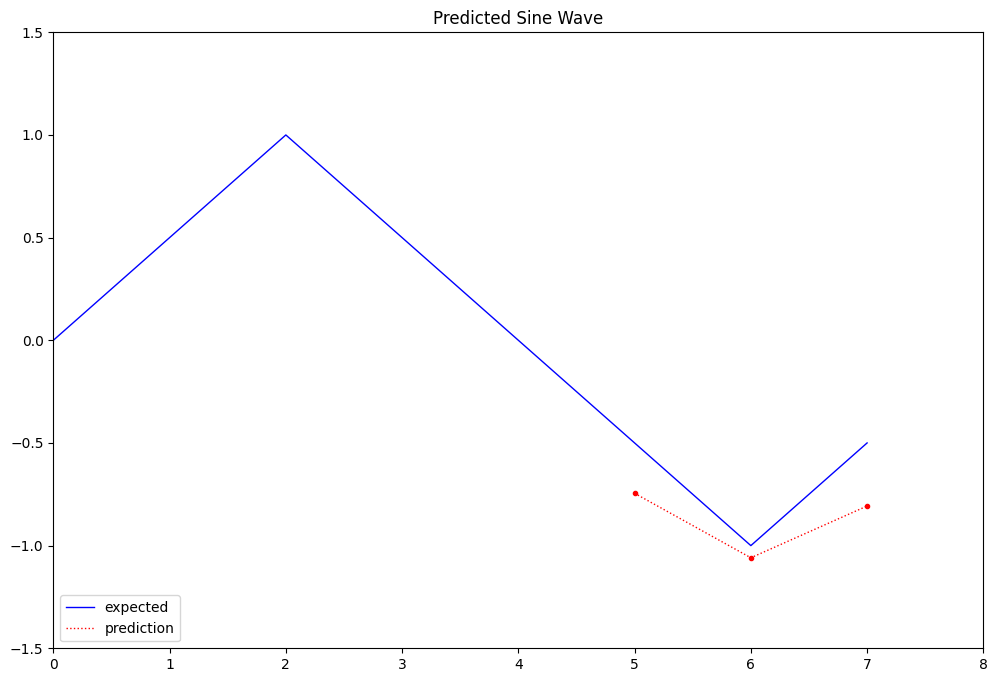

In [67]:
print("Testing Data Predictions")
test_x_axis = np.arange(0,8,1)
test_predict_sq = np.squeeze(test_predict)[:len(y_test)]
plot_predictions(test_x_axis, test, test_predict_sq)

In [71]:
print_differences(y_test, test_predict_sq[:len(y_test)-1])

Expected: -0.5 ==> Predicted: -0.7451602220535278 ==> Diff: 0.24516022205352783
Expected: -1.0 ==> Predicted: -1.0592812299728394 ==> Diff: 0.059281229972839355


Testing Data 2 

Testing 2 Data Predictions


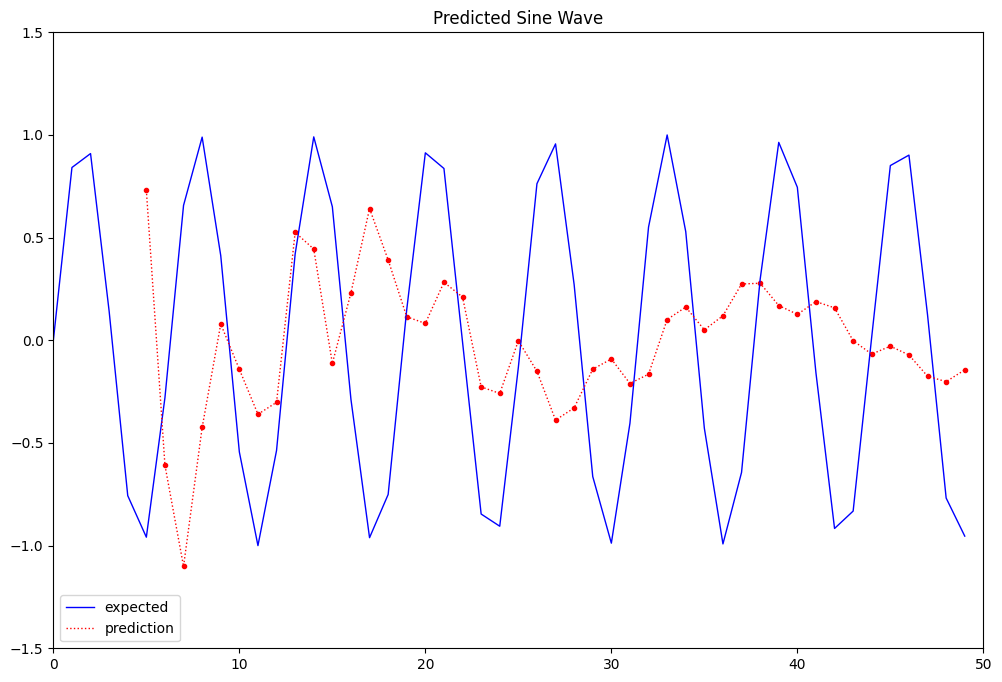

In [72]:
print("Testing 2 Data Predictions")
test2_predict_sq = np.squeeze(test2_predict)
plot_predictions(x_test2_axis, data_test2, test2_predict_sq)

In [73]:
print_differences(data_test2, test2_predict_sq)

Expected: 0.0 ==> Predicted: 0.7310345768928528 ==> Diff: -0.7310345768928528
Expected: 0.8414709848078965 ==> Predicted: -0.6089698672294617 ==> Diff: 1.4504408520373582
Expected: 0.9092974268256817 ==> Predicted: -1.1011019945144653 ==> Diff: 2.0103994213401473
Expected: 0.1411200080598672 ==> Predicted: -0.4247443675994873 ==> Diff: 0.5658643756593545
Expected: -0.7568024953079282 ==> Predicted: 0.07909934222698212 ==> Diff: -0.8359018375349103
Expected: -0.9589242746631385 ==> Predicted: -0.14137794077396393 ==> Diff: -0.8175463338891745
Expected: -0.27941549819892586 ==> Predicted: -0.36024507880210876 ==> Diff: 0.0808295806031829
Expected: 0.6569865987187891 ==> Predicted: -0.30225297808647156 ==> Diff: 0.9592395768052606
Expected: 0.9893582466233818 ==> Predicted: 0.525311291217804 ==> Diff: 0.46404695540557783
Expected: 0.4121184852417566 ==> Predicted: 0.44443604350090027 ==> Diff: -0.032317558259143675
Expected: -0.5440211108893698 ==> Predicted: -0.11279463768005371 ==> Diff

# Archive

## Window Setup: Archive

In [6]:
def get_window_labels(windowed_array, offset):
  return windowed_array[:, :-offset], windowed_array[:, -offset] #windows, labels

In [73]:
def define_window(x, input_size, offset):
  # 1D to 2D array for labelled windows
  window_step = np.expand_dims(np.arange(input_size+offset), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(input_size+offset-1)), axis=0).T # create 2D array of windows of window size

  # print(f"Window index:\n {window_indexes, window_indexes.shape}")

  windowed_array = x[window_indexes]
  # print(f"Values: \n {windowed_array}")

  windows, labels = get_window_labels(windowed_array, offset)

  return windows, labels

In [8]:
# testing window function
train_windows, train_labels = define_window(y_train, input_size, offset)

In [ ]:
for i in range(10):
  print(f"[{train_windows[i]}] ===> [{train_labels[i]}]")

[[0.         0.47942554 0.84147098 0.99749499 0.90929743]] ===> [0.5984721441039565]
[[0.47942554 0.84147098 0.99749499 0.90929743 0.59847214]] ===> [0.1411200080598672]
[[0.84147098 0.99749499 0.90929743 0.59847214 0.14112001]] ===> [-0.35078322768961984]
[[ 0.99749499  0.90929743  0.59847214  0.14112001 -0.35078323]] ===> [-0.7568024953079282]
[[ 0.90929743  0.59847214  0.14112001 -0.35078323 -0.7568025 ]] ===> [-0.977530117665097]
[[ 0.59847214  0.14112001 -0.35078323 -0.7568025  -0.97753012]] ===> [-0.9589242746631385]
[[ 0.14112001 -0.35078323 -0.7568025  -0.97753012 -0.95892427]] ===> [-0.7055403255703919]
[[-0.35078323 -0.7568025  -0.97753012 -0.95892427 -0.70554033]] ===> [-0.27941549819892586]
[[-0.7568025  -0.97753012 -0.95892427 -0.70554033 -0.2794155 ]] ===> [0.21511998808781552]
[[-0.97753012 -0.95892427 -0.70554033 -0.2794155   0.21511999]] ===> [0.6569865987187891]


### Plot labels

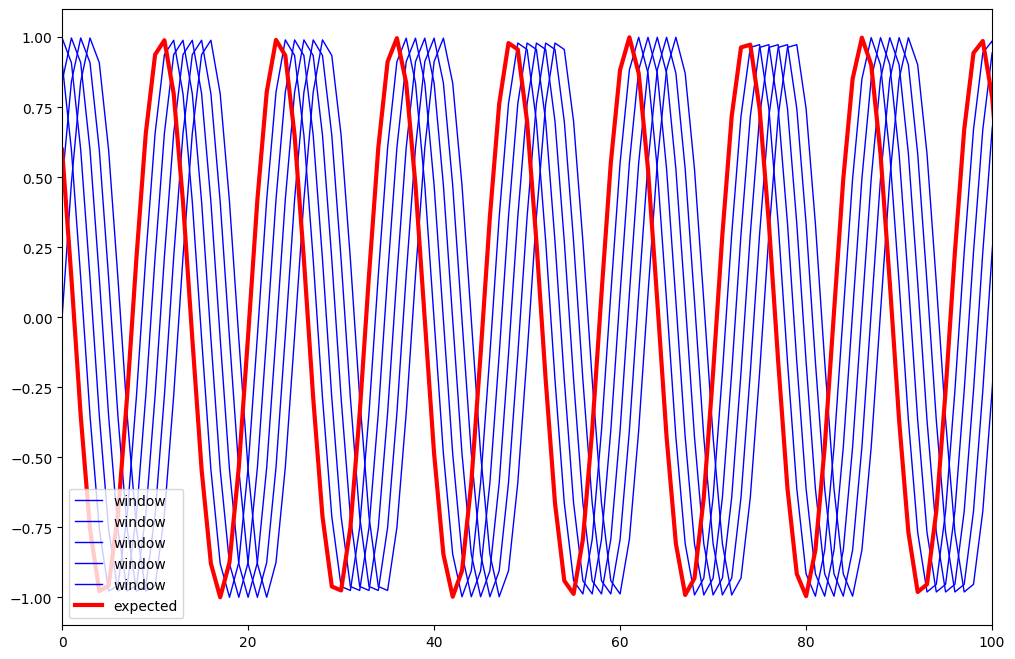

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(train_windows, lw=1, c='b', label='window')
ax.plot(train_labels, lw=3, c='r', label='expected')
ax.legend(loc='lower left')
plt.xlim(0, 100)
plt.show()

#### Not needed? : Validation Split

In [ ]:
def split_window(windows, labels, val_split=0.2):
  size = int(len(windows) * (1-val_split))
  train_windows = windows[:size]
  train_labels = labels[:size]
  val_windows = windows[size:]
  val_labels = labels[size:]
  return train_windows, train_labels, val_windows, val_labels

In [ ]:
train_windows, train_labels, val_windows, val_labels = split_window(windows, labels)

In [ ]:
print(f"training size: {len(train_windows)}")
print(f"validation size: {len(val_windows)}")

training size: 15996
validation size: 3999


In [ ]:
def make_datasets(windows, labels):
  data = windows


##### Archive

In [11]:
train_windows.shape

(19995, 5)

In [12]:
training = np.reshape(train_windows, (train_windows.shape[0], 1, train_windows.shape[1]))
training.shape

(19995, 1, 5)

In [13]:
training_labels = np.reshape(train_labels, (train_labels.shape[0], 1, 1))
training_labels.shape

(19995, 1, 1)

### Archive: Reshape

In [33]:
def reshape_windows(windows, labels=None):
  windows_reshaped = np.reshape(windows, (windows.shape[0], windows.shape[1], 1))
  labels_reshaped = None
  if labels is not None:
    labels_reshaped = np.reshape(labels, (labels.shape[0], 1))
  return windows_reshaped, labels_reshaped

In [28]:
training, training_labels = reshape_windows(train_windows, train_labels)

In [84]:
print(f"Training Shape: {training.shape}")
print(f"Label Shape: {training.shape}")

Training Shape: (19995, 5, 1)
Label Shape: (19995, 5, 1)


In [ ]:
print(f"{training[0]} ==> {training_labels[0]}")
print(f"{training[1]} ==> {training_labels[1]}")

[[0.        ]
 [0.47942554]
 [0.84147098]
 [0.99749499]
 [0.90929743]] ==> [[0.59847214]]
[[0.47942554]
 [0.84147098]
 [0.99749499]
 [0.90929743]
 [0.59847214]] ==> [[0.14112001]]


### Plot

### Tensorboard

In [ ]:
#!lsof -i:6006 

COMMAND     PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
tensorboa 33967 root    3u  IPv4 858590      0t0  TCP localhost:6006 (LISTEN)


In [ ]:
#!kill -9 PID


In [ ]:
#%tensorboard --logdir={logdir}

## Prediction: Archive

WIP -> No success yet

In [81]:
# def predict_loop(dataset, n_predictions, model):
#   results_exp_pred = {}
#   # initial_prediction = model.predict(dataset)
#   initial_prediction = -100
#   dataset = np.append(dataset, initial_prediction)

#   for i in range(n_predictions):
#     windows, expected = define_window(dataset, input_size, offset)
#     windows = reshape_windows(windows)[0]
#     windows = windows[i:] #remove already predicted
#     expected = expected[0]
#     # p = model.predict(windows)
#     p = i+100
#     print(f"Windows, {i}: \n {windows} \n\n Expected: {expected} ==> Predicted: {p}\n")

#     # replace expected with prediction in dataset
#     dataset = np.append(dataset, p)
#     #results.append(p[0][0][0])
#     results_exp_pred[expected] = p

#     print(f'Dataset, {i}: {dataset}\n\n')

#   return results_exp_pred

def predict_loop(dataset, n_predictions, model):
  results = []
  # initial_prediction = model.predict(dataset)
  initial_prediction = -100
  dataset = np.append(dataset, initial_prediction)

  for i in range(n_predictions):
    # windows = define_window(dataset, input_size, offset)[0]
    # windows = reshape_windows(windows)[0]
    # windows = windows[i:] #remove already predicted
    # p = model.predict(windows)
    window = dataset[:input_size-1]
    window = np.reshape(window, (window.shape[0], input_size, 1))

    p = i+100
    print(f"Windows, {i}: \n {window} \n ==> Predicted: {p}\n")

    # replace expected with prediction in dataset
    #dataset = dataset[:-1]
    dataset = np.append(dataset, p)
    #results.append(p[0][0][0])
    results.append(p)

    print(f'Dataset, {i}: {dataset}\n\n')

  return results

In [83]:
x_test.shape

(5,)

In [82]:
# test
p = predict_loop(x_test, len(x_test), model)

Windows, 0: 
 [[[0. ]
  [0.5]
  [1. ]
  [0.5]
  [0. ]]] 
 ==> Predicted: 100

Dataset, 0: [   0.     0.5    1.     0.5    0.  -100.   100. ]


Windows, 1: 
 [[[   0.5]
  [   1. ]
  [   0.5]
  [   0. ]
  [-100. ]]] 
 ==> Predicted: 101

Dataset, 1: [   0.     0.5    1.     0.5    0.  -100.   100.   101. ]


Windows, 2: 
 [[[   1. ]
  [   0.5]
  [   0. ]
  [-100. ]
  [ 100. ]]] 
 ==> Predicted: 102

Dataset, 2: [   0.     0.5    1.     0.5    0.  -100.   100.   101.   102. ]


Windows, 3: 
 [[[   0.5]
  [   0. ]
  [-100. ]
  [ 100. ]
  [ 101. ]]] 
 ==> Predicted: 103

Dataset, 3: [   0.     0.5    1.     0.5    0.  -100.   100.   101.   102.   103. ]


Windows, 4: 
 [[[   0.]
  [-100.]
  [ 100.]
  [ 101.]
  [ 102.]]] 
 ==> Predicted: 104

Dataset, 4: [   0.     0.5    1.     0.5    0.  -100.   100.   101.   102.   103.
  104. ]




In [ ]:
# def plot_results(training_data, training_labels, predictions, title):
#   pred_N = len(predictions)/2 
#   x = np.arange(2, (2+pred_N), 0.5) # shift = 1 / freq = 2
#   fig, ax = plt.subplots(1, 1, figsize=(12,8))
#   ax.plot(training_data, training_labels, lw=1, c='b', label='training data')
#   plt.scatter(training_data, training_labels, marker='.', c='g', label='expected')
#   plt.scatter(x, predictions, marker='X', c='r', label='prediction')
#   #ax.plot(x, predictions, lw=3, c='r', linestyle=':', label='prediction')
#   ax.legend(loc='lower left')
#   plt.xlim(0, pred_N)
#   plt.title(f'{title}')
#   plt.show()

## Plotting: Archive

In [ ]:
testing_data = np.reshape(x_test, (1, 1, x_test.shape[0]))
testing_data.shape

(1, 1, 5)

In [ ]:
testing_data

array([[[0. , 0.5, 1. , 0.5, 0. ]]])

In [ ]:
predictions = predict_loop(testing_data, 10, model)
predictions

1/1 [==============================] - 0s 25ms/step


[0.08914441,
 -0.5622868,
 -0.38057113,
 -0.3771664,
 -0.24872859,
 -0.5811183,
 0.20942795,
 -0.16674897,
 0.55524445,
 -0.029116958]

In [ ]:
print(f"[ predicted ==> expected ==> difference ] ")
for i in range(len(y_test)):
  print(f"{predictions[i]} ==> {y_test[i]} ==> {y_test[i] - predictions[i]}")

[ predicted ==> expected ==> difference ] 
0.08914440870285034 ==> -0.5 ==> -0.5891444087028503
-0.5622867941856384 ==> -1.0 ==> -0.4377132058143616
-0.3805711269378662 ==> -0.5 ==> -0.11942887306213379


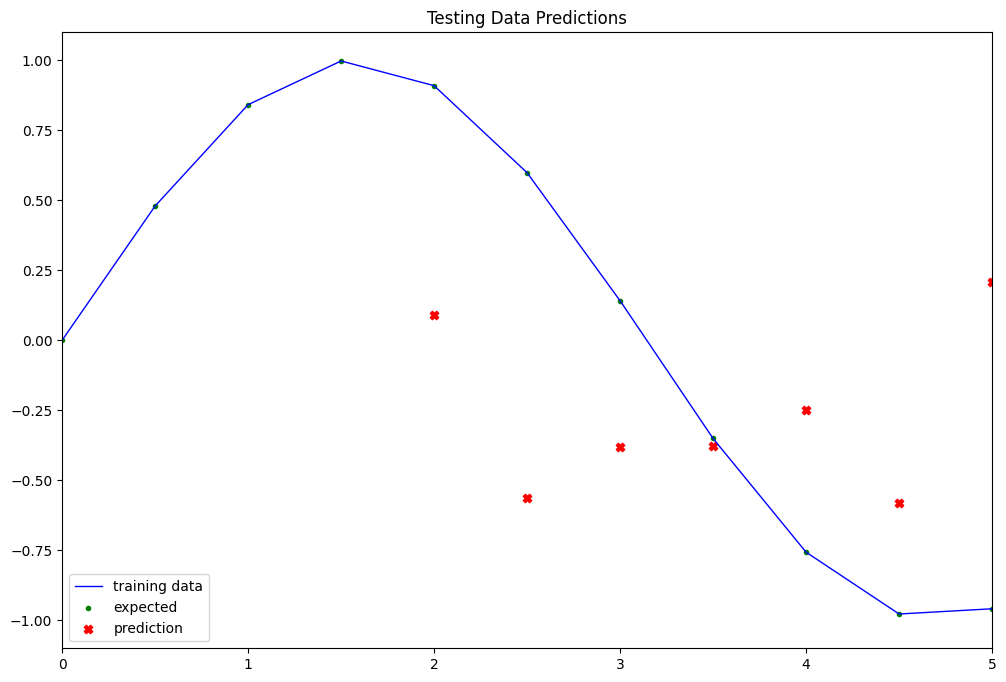

In [ ]:
#predictions = np.reshape(predictions, (predictions.shape[0],))
plot_results(x_train, y_train, predictions, 'Testing Data Predictions')